In [3]:
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False

In [4]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA, TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, silhouette_samples, mean_squared_error
from sklearn.random_projection import GaussianRandomProjection
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from numpy import linalg as LA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy
from scipy.linalg import pinv
import pandas as pd

import itertools
import scipy.stats

import time

import warnings
warnings.filterwarnings('ignore')

# import plotly.offline as py
# py.init_notebook_mode(connected=True)

# import plotly.graph_objs as go

from sklearn.preprocessing import StandardScaler

# Data

In [5]:
df = pd.read_csv('data/minist_train.csv')

df_sample = df.sample(10000)

y = df_sample[df_sample.columns[0]]
X = df_sample[df_sample.columns[1:]]

# split the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dimensionality Reduction

## PCA

In [6]:
X_PCA = PCA(n_components = 5).fit_transform(X)
X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(X_PCA, y, test_size=0.2, random_state=42)

## ICA

In [7]:
X_ICA = FastICA(n_components = 5).fit_transform(X)
X_ICA_train, X_ICA_test, y_ICA_train, y_ICA_test = train_test_split(X_ICA, y, test_size=0.2, random_state=42)

## RP

In [8]:
X_RP = GaussianRandomProjection(n_components = 5).fit_transform(X)
X_RP_train, X_RP_test, y_RP_train, y_RP_test = train_test_split(X_RP, y, test_size=0.2, random_state=42)

## Feature Selection using Trees

In [9]:
etc = ExtraTreesClassifier(n_estimators = 100)
etc = etc.fit(X,y)
model = SelectFromModel(etc, prefit=True)
X_Trees = model.transform(X)
X_Trees_train, X_Trees_test, y_Trees_train, y_Trees_test = train_test_split(X_Trees, y, test_size=0.2, random_state=42)

# Neural Network with Dimensionality Reduction

## Nominal Performance

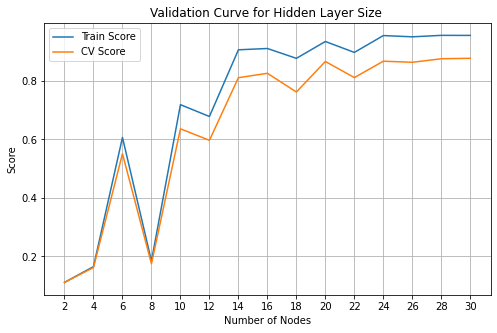

In [10]:
classifier_neural_network = MLPClassifier(random_state=42, max_iter=2000)
train_scores, test_scores = validation_curve(classifier_neural_network, X_train, y_train, param_name="hidden_layer_sizes", param_range=np.arange(2,31,2), cv=4)

plt.figure(figsize=(8,5))
plt.plot(np.arange(2,31,2), np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.arange(2,31,2), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Hidden Layer Size ")
plt.xlabel("Number of Nodes")
plt.ylabel("Score")
plt.grid()
plt.xticks(np.arange(2,31,2))
plt.savefig('minist_neural_network_validation_curve.png')
plt.show()

In [11]:
param_grid = {'alpha': np.logspace(-3,3,7), 'hidden_layer_sizes': np.arange(2,25,2)}
classifier_neural_network_best = GridSearchCV(classifier_neural_network, param_grid=param_grid, cv=2)

start_time = time.time()
classifier_neural_network_best.fit(X_train, y_train)
end_time = time.time()
time_train = end_time-start_time
print("Best params for neural network:",classifier_neural_network_best.best_params_)
print("Time to train:",time_train)

start_time = time.time()
classifier_accuracy = accuracy_score(y_test, classifier_neural_network_best.predict(X_test))
end_time = time.time()
time_infer = end_time-start_time
print("Accuracy for best neural network:", classifier_accuracy)
print("Time to infer:",time_infer)

Best params for neural network: {'alpha': 100.0, 'hidden_layer_sizes': 24}
Time to train: 1870.1524159908295
Accuracy for best neural network: 0.939
Time to infer: 0.011673927307128906


In [12]:
confusion_matrix(y_test, classifier_neural_network_best.predict(X_test))

array([[200,   0,   3,   1,   0,   1,   1,   0,   0,   0],
       [  0, 210,   1,   1,   1,   0,   0,   0,   1,   1],
       [  0,   3, 185,   0,   4,   0,   3,   0,   1,   2],
       [  0,   3,   2, 196,   0,   2,   3,   0,   0,   0],
       [  0,   0,   1,   0, 165,   0,   1,   0,   2,   5],
       [  0,   3,   1,   8,   1, 158,   1,   1,   1,   1],
       [  0,   0,   0,   0,   1,   2, 192,   0,   1,   0],
       [  0,   0,   4,   0,   2,   1,   0, 203,   0,   3],
       [  0,   5,   4,  10,   0,   2,   2,   0, 184,   4],
       [  1,   0,   0,   2,  10,   3,   1,   3,   1, 185]])

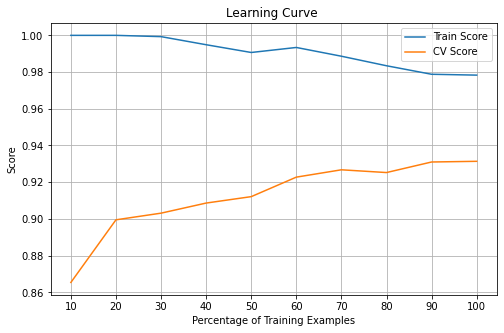

In [13]:
classifier_neural_network_learning = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=classifier_neural_network_best.best_params_['hidden_layer_sizes'], alpha=classifier_neural_network_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_train, y_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve ")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('minist_neural_network_learning_curve.png')
plt.show()

## PCA

In [14]:
classifier_neural_network = MLPClassifier(random_state=42, max_iter=2000)
param_grid = {'alpha': np.logspace(-3,3,7), 'hidden_layer_sizes': np.arange(2,25,2)}
classifier_neural_network_best = GridSearchCV(classifier_neural_network, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_neural_network_best.fit(X_PCA_train, y_PCA_train)
end_time = time.time()
time_train = end_time-start_time
print("Best params for neural network:",classifier_neural_network_best.best_params_)
print("Time to train:",time_train)

start_time = time.time()
classifier_accuracy = accuracy_score(y_PCA_test, classifier_neural_network_best.predict(X_PCA_test))
end_time = time.time()
time_infer = end_time-start_time
print("Accuracy for best neural network:", classifier_accuracy)
print("Time to infer:",time_infer)

Best params for neural network: {'alpha': 100.0, 'hidden_layer_sizes': 24}
Time to train: 1191.4144530296326
Accuracy for best neural network: 0.7265
Time to infer: 0.0016140937805175781


In [15]:
confusion_matrix(y_PCA_test, classifier_neural_network_best.predict(X_PCA_test))

array([[185,   0,   1,   0,   1,  10,   1,   0,   8,   0],
       [  0, 198,   1,   4,   1,   0,   2,   4,   3,   2],
       [  3,   4, 121,   6,   6,   6,  46,   0,   6,   0],
       [  0,   2,   4, 152,   0,  23,   2,   1,  22,   0],
       [  1,   2,   0,   0, 135,   0,   9,   8,   0,  19],
       [  6,   0,   3,  28,   2, 113,   4,   7,  12,   0],
       [  3,   5,  29,   0,  10,   5, 134,   0,  10,   0],
       [  0,   1,   0,   0,  18,   2,   2, 183,   2,   5],
       [  1,   2,   5,  21,   7,  15,   1,   1, 150,   8],
       [  2,   1,   0,   3,  66,   5,   2,  38,   7,  82]])

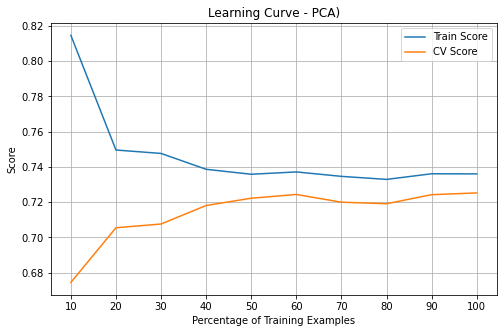

In [16]:
classifier_neural_network_learning = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=classifier_neural_network_best.best_params_['hidden_layer_sizes'], alpha=classifier_neural_network_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_PCA_train, y_PCA_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve - PCA)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('minist_neural_network_learning_curve_pca.png')
plt.show()

## ICA

In [17]:
classifier_neural_network = MLPClassifier(random_state=42, max_iter=2000)
param_grid = {'alpha': np.logspace(-3,3,7), 'hidden_layer_sizes': np.arange(2,25,2)}
classifier_neural_network_best = GridSearchCV(classifier_neural_network, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_neural_network_best.fit(X_ICA_train, y_ICA_train)
end_time = time.time()
time_train = end_time-start_time
print("Best params for neural network:",classifier_neural_network_best.best_params_)
print("Time to train:",time_train)

start_time = time.time()
classifier_accuracy = accuracy_score(y_ICA_test, classifier_neural_network_best.predict(X_ICA_test))
end_time = time.time()
time_infer = end_time-start_time
print("Accuracy for best neural network:", classifier_accuracy)
print("Time to infer:",time_infer)

Best params for neural network: {'alpha': 0.001, 'hidden_layer_sizes': 14}
Time to train: 1797.3466622829437
Accuracy for best neural network: 0.663
Time to infer: 0.0015716552734375


In [18]:
confusion_matrix(y_ICA_test, classifier_neural_network_best.predict(X_ICA_test))

array([[176,   0,   2,   0,   0,  16,   2,   1,   9,   0],
       [  0, 199,   4,   4,   0,   1,   0,   2,   4,   1],
       [  6,   5, 114,   7,   9,   3,  48,   1,   5,   0],
       [  1,   2,   5, 148,   0,  25,   3,   2,  18,   2],
       [  1,   2,   1,   0, 101,   1,  10,   7,   2,  49],
       [  4,  11,  10,  42,   3,  78,   4,  13,   8,   2],
       [  4,   6,  40,   1,  13,   5, 117,   1,   9,   0],
       [  0,   4,   0,   0,   7,   2,   0, 179,   4,  17],
       [  2,   8,   8,  37,   2,  16,   2,   0, 124,  12],
       [  5,   2,   0,   2,  51,   2,   4,  39,  11,  90]])

In [19]:
X_ICA_train.shape

(8000, 5)

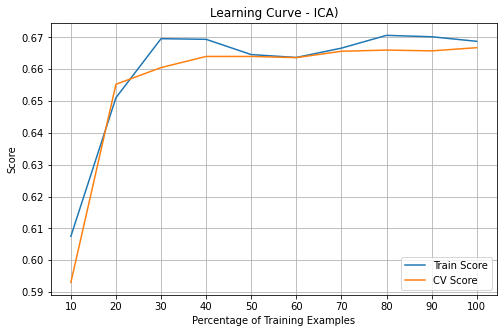

In [20]:
classifier_neural_network_learning = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=classifier_neural_network_best.best_params_['hidden_layer_sizes'], alpha=classifier_neural_network_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_ICA_train, y_ICA_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve - ICA)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('minist_neural_network_learning_curve_ica.png')
plt.show()

## RP

In [21]:
classifier_neural_network = MLPClassifier(random_state=42, max_iter=2000)
param_grid = {'alpha': np.logspace(-3,3,7), 'hidden_layer_sizes': np.arange(2,25,2)}
classifier_neural_network_best = GridSearchCV(classifier_neural_network, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_neural_network_best.fit(X_RP_train, y_RP_train)
end_time = time.time()
time_train = end_time-start_time
print("Best params for neural network:",classifier_neural_network_best.best_params_)
print("Time to train:",time_train)

start_time = time.time()
classifier_accuracy = accuracy_score(y_RP_test, classifier_neural_network_best.predict(X_RP_test))
end_time = time.time()
time_infer = end_time-start_time
print("Accuracy for best neural network:", classifier_accuracy)
print("Time to infer:",time_infer)

Best params for neural network: {'alpha': 1000.0, 'hidden_layer_sizes': 22}
Time to train: 1073.0305490493774
Accuracy for best neural network: 0.4185
Time to infer: 0.0017452239990234375


In [22]:
accuracy_score(y_RP_train, classifier_neural_network_best.predict(X_RP_train))

0.4305

In [23]:
confusion_matrix(y_RP_test, classifier_neural_network_best.predict(X_RP_test))

array([[126,  11,   2,   8,  11,   8,   5,   7,  19,   9],
       [  0, 178,   8,   9,   0,   0,   5,   4,  11,   0],
       [  9,  43,  80,   4,   1,   2,  32,   6,  19,   2],
       [ 36,  24,   6,  42,   5,  32,   9,  10,  26,  16],
       [ 14,  24,   1,  19,  21,  22,  18,  21,  11,  23],
       [ 27,  22,   4,  16,   2,  45,   9,  16,  20,  14],
       [ 12,  21,   9,   5,   7,   2,  88,  33,  18,   1],
       [  3,  20,   3,   6,   6,   9,  19, 123,   3,  21],
       [ 25,  25,   8,  15,   7,  16,  12,  12,  81,  10],
       [ 16,   4,   0,  23,  20,  35,   7,  37,  11,  53]])

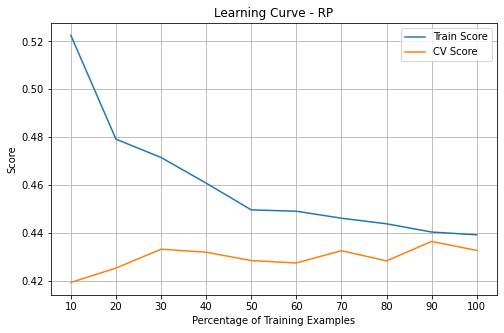

In [24]:
classifier_neural_network_learning = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=classifier_neural_network_best.best_params_['hidden_layer_sizes'], alpha=classifier_neural_network_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_RP_train, y_RP_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve - RP")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('minist_neural_network_learning_curve_rp.png')
plt.show()

## Dimensionality Reduction using Trees

In [25]:
classifier_neural_network = MLPClassifier(random_state=42, max_iter=2000)
param_grid = {'alpha': np.logspace(-3,3,7), 'hidden_layer_sizes': np.arange(2,25,2)}
classifier_neural_network_best = GridSearchCV(classifier_neural_network, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_neural_network_best.fit(X_Trees_train, y_Trees_train)
end_time = time.time()
time_train = end_time-start_time
print("Best params for neural network:",classifier_neural_network_best.best_params_)
print("Time to train:",time_train)

start_time = time.time()
classifier_accuracy = accuracy_score(y_Trees_test, classifier_neural_network_best.predict(X_Trees_test))
end_time = time.time()
time_infer = end_time-start_time
print("Accuracy for best neural network:", classifier_accuracy)
print("Time to infer:",time_infer)

Best params for neural network: {'alpha': 100.0, 'hidden_layer_sizes': 22}
Time to train: 21670.414386749268
Accuracy for best neural network: 0.9265
Time to infer: 0.003094911575317383


In [26]:
confusion_matrix(y_Trees_test, classifier_neural_network_best.predict(X_Trees_test))

array([[197,   0,   2,   2,   0,   2,   0,   2,   0,   1],
       [  0, 209,   1,   3,   1,   0,   0,   0,   1,   0],
       [  1,   2, 173,   3,   7,   3,   4,   3,   1,   1],
       [  0,   0,   1, 193,   1,   9,   0,   1,   0,   1],
       [  0,   0,   0,   0, 165,   0,   2,   0,   0,   7],
       [  0,   2,   0,   5,   1, 160,   2,   1,   1,   3],
       [  1,   0,   0,   0,   3,   3, 188,   0,   1,   0],
       [  0,   0,   0,   1,   3,   0,   0, 209,   0,   0],
       [  0,   1,   2,   9,   2,  13,   0,   1, 171,  12],
       [  2,   0,   0,   2,   7,   2,   0,   4,   1, 188]])

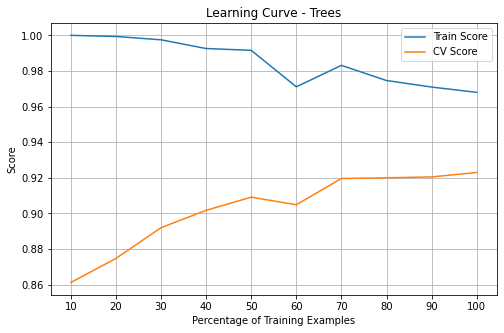

In [27]:
classifier_neural_network_learning = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=classifier_neural_network_best.best_params_['hidden_layer_sizes'], alpha=classifier_neural_network_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_Trees_train, y_Trees_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve - Trees")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('minist_neural_network_learning_curve_trees.png')
plt.show()